## Neural Radiance Fields (NeRF)

### What a NeRF is?

NeRF was first introduced in a 2020 in a paper [NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://arxiv.org/abs/2003.08934). A Neural Radiance Field models a 3D scene as a continuous function:

$$
    (\mathbf{x} \in \mathbb{R}^3, \mathbf{d} \in \mathbb{S}^2) \rightarrow (\sigma, \mathbf{c}),
$$

where $\mathbf{x}$ is a point in 3D space, and $\mathbf{d}$ is a viewing direction (point on a three dimensional unit sphere). The underlying MLP predicts two quantities: $\sigma$, the volume density, and $\mathbf{c}$, the color.
Images are rendered by marching rays from camera pixels through the scene, sampling many points, and alpha-compositing the colors using the predicted densities - differentiable volume rendering.

<p align="center">
  <img src="figures/pipeline.jpg" />
</p>

### Rendering

endering an image amounts to accumulating radiance along each camera ray. Each ray from the camera can be represented by an origin $\mathbf{p} \in \mathbb{R}^3$ and a unit direction $\mathbf{d} \in \mathbb{S}^2$. For the $(i, j)$-th raythe points along the ray are parameterized by:

$$
    \mathbf{r}_{ij}(t) = \mathbf{p} + \mathbf{d}t, \; \text{where } t \in (0, \infty).
$$

The color of $(i, j)$ pixel is given by

$$
    C_{ij} = \int T(t) 
        \underbrace{\sigma(\mathbf{r}_{ij}(t))}_{\text{volume density at current point | }}
        \underbrace{\mathbf{c}(\mathbf{r}_{ij}(t), \mathbf{d})}_{\text{color emitted along} \mathbf{d}} \text{d}t.
$$

The function $T(t)$ is the accumulated transmittance (survival probability) along a ray from its origin up to depth $t$. Using Beer-Lambert law we arrive at equation:

$$
    T(t) = \exp \Big( −\int_0^t \sigma(\mathbf{r}_{ij}(s)) \text{d}s \Big).
$$

When it comes to rendering physical scene, the $\mathbf{C}_{ij}$ integral is often evaluate on the interval $[t_n, t_f]$ which corresponds to the values between near and far plane. 

### Improvements

Here are known improvements to this basic NeRF model:

- Because there is a lot of empty spots when sampling the densities, authors suggest simultaneously optimize two networks: one "coarse" and one "fine". First we sample the "coarse" network $N_C$ using sampling described above, using the $\sigma$ values at each point, we are able to compute more informed points $N_f$ and sample the "fine" network on the union of two sets $N_C+N_F$.

- Improved method: [Zip-NeRF: Anti-Aliased Grid-Based Neural Radiance Fields](https://arxiv.org/abs/2304.06706) - uses cone tracing with grid encodings, greatly reduces noise and depth aliasing.

- New method: [Gaussian Splatting](https://arxiv.org/abs/2308.04079) - represents the scene with 3D Gaussians that preserve desirable properties of continuous volumetric radiance fields for scene optimization while avoiding unnecessary computation in empty space.


### Tutorial

The dataset is in the `/data` directory. It consists of procedurally generated photos of a LEGO truck. For each sample in a training batch, we need:

- **Image**  
$$
    \mathbf{I}_i \in [0,1]^{H \times W \times 3}
$$

- **Pose matrix** — camera-to-world transformation for each image.  
  The top-left $3 \times 3$ block is rotation; the first three entries of the last column are the camera origin in world coordinates.  
$$
    \mathbf{T}_i \in \mathbb{R}^{4 \times 4}
$$

- **Focal length** of the camera as a scalar $f \in \mathbb{R}$.

First, we load the training data. Activate the virtual environment and install the required packages with `uv sync`.


Device: cpu
Shape of train images:  torch.Size([100, 80, 80, 3])
Shape of poses:  torch.Size([100, 4, 4])
Focal:  111.11110311937682


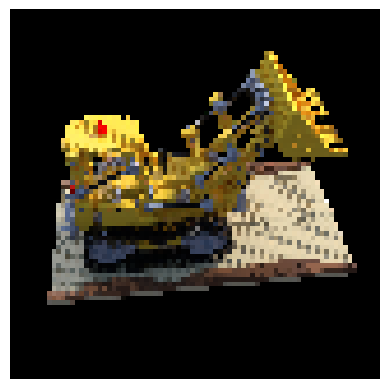

In [51]:
# import packages
import json

import PIL as pil
import numpy as np
import matplotlib.pyplot as plt
import imageio

from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

# load images and other informations
DATA_ROOT = "./data"

def load_split(root: str, subsample: int = 10, split: str ="train"):
    with open(f"{root}/transforms_{split}.json", "r") as file:
        data = json.load(file)
        imgs, poses = [], []
        for frame in data["frames"]:
            image_path = f"{root}/{frame['file_path'][2:]}.png"

            # subsample and append image
            img = np.array(pil.Image.open(image_path).convert("RGB"))
            if subsample > 1:
                img = img[::subsample, ::subsample]
            imgs.append(img)

            # append pose
            poses.append(np.array(frame["transform_matrix"], dtype=np.float32))

    # normalize images and cast poses
    imgs = np.array(imgs).astype(np.float32) / 255.0
    poses = np.array(poses).astype(np.float32)
    H, W = imgs[0].shape[:2]

    # get focal from camera_angle_x
    focal = 0.5 * W / np.tan(0.5 * data["camera_angle_x"])
    return torch.from_numpy(imgs), torch.from_numpy(poses), H, W, focal

imgs_train, poses_train, H, W, focal = load_split(DATA_ROOT)
print("Shape of train images: ", imgs_train.shape)
print("Shape of poses: ", poses_train.shape)
print("Focal: ", focal)

plt.imshow(imgs_train[5].cpu().detach().numpy())
plt.axis("off")
plt.show();

Now we need to prepare two functions responsible for the rendering of the scene. `get_rays` will generate a grid of direction vectors for given camera-to-world transformation matrix. Basically we can prepare direction vectors in the normal coordinate system (origins in $\mathbf{0}$) and then apply $\mathbf{T}_i$ matrix to transform them to the camera world. It is performed using:

$$
    \mathbf{d}_{\text{world}} = \mathbf{d}_{\text{camera}} \mathbf{R}_i,
$$
where $\mathbf{R}$ is the top $3 \times 3$ part of $\mathbf{T}_i$ representing the rotation part. The origins are all the same for every vector and are represented by the last column of $\mathbf{T}_i$.


<p align="center">
  <img src="figures/camtransform.png" />
</p>

Second function, `render_rays`, will perform volume rendering. First we draw linear samples from the interval $[t_n, t_f]$, but to futher increase the versitality of the underlying MLP approximation authors suggest using a stratified sampling approach where we partition [tn, tf ] into N evenly-spaced bins and then draw one sample uniformly at random from within each bin:

$$
    t_i  \sim \mathcal{U} \Big[t_n + \frac{i+1}{N}(t_f - t_n), t_n + \frac{i}{N}(t_f - t_n) \Big].
$$


In [ ]:
from abc import ABC

class ModelBase(nn.Module, ABC):    
    pass

def _prepare_direction_mesh(focal: float, H: int, W: int) -> torch.Tensor:
    # create a grid of values scaled by H and W
    i, j = torch.meshgrid(torch.arange(W, device=DEVICE), torch.arange(H, device=DEVICE), indexing='xy')
    cx, cy = W * 0.5, H * 0.5
    # pinhole camera
    return torch.stack([(i - cx)/focal, -(j - cy)/focal, -torch.ones_like(i)], -1)

def get_rays(dir_mesh: torch.Tensor, camera_to_world: torch.Tensor):
    # get the camera direction in world coordinate system
    rays_dir = dir_mesh @ camera_to_world[:3, :3].T
    # origins are the same for each vector
    rays_origin = camera_to_world[:3, 3].expand(rays_dir.shape)
    # normalize ray_direcrions
    return rays_origin, F.normalize(rays_dir, dim=-1) 

def render_rays(
    model: ModelBase, 
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    near_plane=1.0,
    far_plane=6.0,
    n_samples=32,
    perturb=True
):
    # sample depths
    t_vals = torch.linspace(0.0, 1.0, n_samples, device=DEVICE)
    # linear interploate between near and fat planes
    z_vals = near_plane * (1.0 - t_vals) + far_plane * t_vals
    # cast to the size of ray object
    z_vals = z_vals.expand(rays_o.shape[:-1] + (n_samples,))

    # perturn values - draw from uniform bins
    if perturb:
        mids = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
        upper = torch.cat([mids, z_vals[..., -1:]], -1)
        lower = torch.cat([z_vals[..., :1], mids], -1)
        t_rand = torch.rand(z_vals.shape, device=DEVICE)
        z_vals = lower + (upper - lower) * t_rand

    # points along rays r_ij(t) = o_ij + d_ij * t
    # rays are of size (H, W, 3) and z_vals is (H, W, n)
    # we can make it into (H, W, 1, 3) and (H, W, n, 1) and perform elementwise multiplication
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., None]
    dirs = rays_d[..., None, :].expand_as(pts)

    # query network with aggregated points and direcrions
    B = pts.shape[:-1]
    rgb, sigma = model(pts.reshape(-1,3), dirs.reshape(-1,3))
    # reshape rbg and sigma back to initial shape
    rgb = rgb.reshape(B + (3,))
    sigma = sigma.reshape(B)

    # volumetric compositing
    deltas = z_vals[..., 1:] - z_vals[..., :-1]
    delta_last = 1e10 * torch.ones_like(deltas[..., :1])
    deltas = torch.cat([deltas, delta_last], -1)

    # alpha_i: per-sample opacity in [0,1]
    # (sigma_i is predicted density, deltas_i is the distance to the next sample)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    survival = 1.0 - alpha + 1e-10 

    survival_with_one = torch.cat(
        [torch.ones_like(survival[..., :1]), survival],
        dim=-1
    )

    cumprod_inclusive = torch.cumprod(survival_with_one, dim=-1)
    T = cumprod_inclusive[..., :-1]
    weights = T * alpha

    rgb_map = torch.sum(weights[..., None] * rgb, -2)
    depth_map = torch.sum(weights * z_vals, -1)
    return rgb_map, depth_map

With helper functions written, we can finally define the model. Authors found that MLP which directly operate on $xyz\theta\phi$ input coordinates results in renderings that perform poorly at representing high-frequency variation in color and geometry. They leverage positional embedding to mitigate those effect. They define an embedding function $\gamma: \mathbb{R} \rightarrow \mathbb{R}^{2L}$ as:

$$
 \gamma(p) = \Big(\sin(2^0 \pi p), \cos(2^0 \pi p),\cdots, \sin(2^{L - 1} \pi p), \cos(2^{L - 1}\pi p) \Big)
$$

In [53]:
class PosEnc(nn.Module):
    def __init__(self, in_dims, num_freqs=10):
        super().__init__()
        self.in_dims = in_dims
        self.num_freqs = num_freqs
        self.freqs = 2.0 ** torch.arange(num_freqs)

    @property
    def out_dims(self):
        return self.in_dims * (self.num_freqs * 2  + 1)

    def forward(self, x):
        enc = [x]
        for f in self.freqs:
            enc += [torch.sin(f * x), torch.cos(f * x)]
        return torch.cat(enc, dim=-1)
    

class TinyNeRF(nn.Module):
    def __init__(self, Lx=10, Ld=4, dim=128):
        super().__init__()
        # encoding layers
        self.pe_x = PosEnc(3, Lx)
        self.pe_d = PosEnc(3, Ld)
        in_x = self.pe_x.out_dims
        in_d = self.pe_d.out_dims

        # MLP
        self.fc1 = nn.Linear(in_x, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.fc3 = nn.Linear(dim, dim)
        self.fc4 = nn.Linear(dim + in_x, dim) # residual connection
        self.fc_sigma = nn.Linear(dim, 1)

        self.fc_feat = nn.Linear(dim, dim)
        self.fc_dir  = nn.Linear(dim + in_d, dim//2)
        self.fc_rgb  = nn.Linear(dim//2, 3)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); 
                nn.init.zeros_(m.bias)

    def forward(self, x, d):
        # x: (...,3) points 
        # d: (...,3) ray dirs

        # encoding and infering coordinates
        x_enc = self.pe_x(x)
        y = F.relu(self.fc1(x_enc))
        y = F.relu(self.fc2(y))
        y = F.relu(self.fc3(y))

        # residual 
        y = torch.cat([x_enc, y], dim=-1)
        y = F.relu(self.fc4(y))

        # output
        sigma = F.relu(self.fc_sigma(y))

        # use coodinates as additional features for estimating rgb
        # and concat them with embedded angle
        d_enc = self.pe_d(d)
        feat = F.relu(self.fc_feat(y))

        y_dir = torch.cat([feat, d_enc], dim=-1)
        y_dir = F.relu(self.fc_dir(y_dir))

        # output
        rgb = torch.sigmoid(self.fc_rgb(y_dir))
        return rgb, sigma

With the model and all helped functions defines we can finally begin training.

In [ ]:
DIR_MESH = _prepare_direction_mesh(focal, H, W)

model = TinyNeRF(Lx=10, Ld=4, dim=32).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=5e-4)

near, far = 1.0, 6.0    # blender synthetic scenes
n_samples = 32          # samples per ray
batch_rays = 1024       # rays per step
steps = 15_000          # training steps
show_every = 1_000

imgs = imgs_train.to(DEVICE)
poses = poses_train.to(DEVICE)

# precompute rays for all train images
all_rays_o, all_rays_d, all_rgbs = [], [], []

for i in range(imgs.shape[0]):
    ro, rd = get_rays(DIR_MESH, poses[i])
    all_rays_o.append(ro.reshape(-1, 3))
    all_rays_d.append(rd.reshape(-1, 3))
    all_rgbs.append(imgs[i].reshape(-1, 3))

all_rays_o = torch.cat(all_rays_o, 0)
all_rays_d = torch.cat(all_rays_d, 0)
all_rgbs   = torch.cat(all_rgbs, 0)
N_total_rays = all_rays_o.shape[0]
print("Total train rays:", N_total_rays)

bar = tqdm(range(1, steps + 1),
    desc="Training",
    unit="step",
    dynamic_ncols=True,
    smoothing=0.1,
    leave=True
)

# traning loop
model.train()
for step in bar:
    # pick random batch of rays (not from one image, but from all of the rays)
    idx = torch.randint(0, N_total_rays, (batch_rays,), device=DEVICE)
    rays_o = all_rays_o[idx]
    rays_d = all_rays_d[idx]
    target = all_rgbs[idx]

    # infer model and backpropagate
    rgb_pred, _ = render_rays(model, rays_o, rays_d, near, far, n_samples=n_samples)
    loss = F.mse_loss(rgb_pred, target)
    optim.zero_grad()
    loss.backward()
    optim.step()

    if step % 50 == 0:
        psnr = -10.0 * torch.log10(loss.detach())
        bar.set_postfix(loss=f"{loss.item():.5f}", psnr=f"{psnr:.2f}")

    if step % show_every == 0:
        model.eval()
        with torch.no_grad():
            # render fifth train view (low-res)
            ro, rd = get_rays(DIR_MESH, poses[5])
            ro, rd = ro.reshape(-1,3), rd.reshape(-1,3)
            rgb, _ = render_rays(model, ro, rd, near, far, n_samples=n_samples, perturb=False)
            img_pred = rgb.reshape(H, W, 3).clamp(0,1).cpu().numpy()
            img_gt   = imgs[5].cpu().numpy()

            # preview
            side_by_side = (np.hstack([img_gt, img_pred]) * 255).astype(np.uint8)
            plt.imshow(side_by_side)
            plt.axis('off')
            plt.show()
            
        model.train()

Given the trained model, we can generate a gif of rotating around our modeled scene. 

In [ ]:
def pose_spherical(theta_deg, radius, z=2.8):
    theta = np.deg2rad(theta_deg)

    # camera position on a circle at height z
    cam_pos = np.array([
        radius * np.cos(theta),
        radius * np.sin(theta),
        z
    ], dtype=np.float32)

    target   = np.array([0, 0, 0], dtype=np.float32)
    world_up = np.array([0, 0, 1], dtype=np.float32)

    # view direction from camera to target
    forward = target - cam_pos
    forward /= np.linalg.norm(forward)

    # duild a right-handed camera frame where z_cam = -forward
    z_cam = -forward
    # right
    x_cam = np.cross(world_up, z_cam); x_cam /= np.linalg.norm(x_cam)  
    # up (orthonormal)
    y_cam = np.cross(z_cam, x_cam)

    # camera-to-world: columns are the camera axes expressed in world coords
    c2w = np.eye(4, dtype=np.float32)
    c2w[:3, :3] = np.stack([x_cam, y_cam, z_cam], axis=1)
    # translation
    c2w[:3, 3]  = cam_pos 
    return torch.from_numpy(c2w).to(DEVICE)

n_frames  = 120
radius    = 4

model.eval()
imgs = []
for i in trange(n_frames):
    theta = i * 360.0 / n_frames
    c2w = pose_spherical(theta, radius)
    ro, rd = get_rays(DIR_MESH, c2w)
    ro, rd = ro.reshape(-1,3), rd.reshape(-1,3)
    rgb, _ = render_rays(model, ro, rd, near, far, n_samples=n_samples, perturb=False)
    img_pred = (rgb.reshape(H, W, 3).clamp(0,1).detach().cpu().numpy()*255).astype(np.uint8)
    imgs.append(img_pred)

imageio.mimsave("orbit.gif", imgs, fps=30)

100%|██████████| 120/120 [00:07<00:00, 16.08it/s]


If you run this code with lower subsampling, bigger hidden size and more iterations, you should end up with animation similar to this one.

![](figures/render.gif)